In [241]:
import numpy as np 
from math import pi
import sympy as sy
import matplotlib.pyplot as plt 
from numba import jit
from sklearn.model_selection import train_test_split

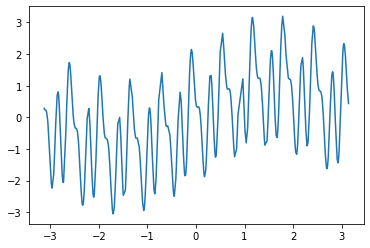

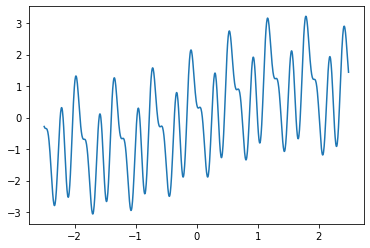

In [242]:
# general random sample 
N = 512
x = np.random.uniform(-pi,pi,2*N)
x.sort()
b1,b2,b3 = np.random.uniform(0,2*pi,3)
y = np.sin(x) + np.sin(10*x+b1) + np.sin(20*x+b2) + np.sin(30*x+b3)

# split the data 
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=0.5)
# print(len(x_tr))
x_ts, y_ts = zip(*sorted(zip(x_ts, y_ts)))

# grid sample
N0 = 1000
dx = 0.005
x0 = np.linspace(-N0/2*dx, (N0/2-1)*dx, N0, endpoint=False)
x0.sort()
y0 = np.sin(x0) + np.sin(10*x0+b1) + np.sin(20*x0+b2) + np.sin(30*x0+b3)

plt.plot(x_ts,y_ts)
plt.show()
plt.plot(x0, y0)
plt.show()

In [243]:
# define the function includes w0

d = 1
px = 1/2/pi
fp = np.sqrt(px) * (y_ts - np.mean(y_ts))
# print(fp)

@jit(nopython=True)
def f_approx(w0):
    f = 0
    for i in range(N-1):
        for j in range(N-1): 
            sinc = 1
            if d == 1: 
                K = [1]
            else: 
                K = range(1,d)
            for k in K: 
                t = w0*(x_ts[j]**k - x_ts[i]**k)
                if t == 0: 
                    sinc = sinc * 1
                else: 
                    sinc = sinc * np.sin(t) / t
            f = f + fp[i]*fp[j]/px/px * (w0/pi)**d * sinc 
    f = f * 2 / (N**2)
    return f      

# print(f_approx(10))

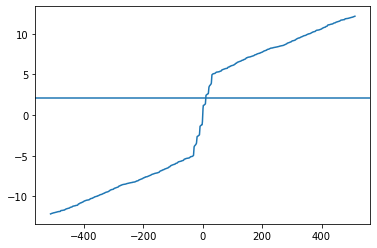

In [244]:
W = np.linspace(-N, N, 2*N+1)
# print(W)
f_w = np.zeros(2*N+1)

for w in W: 
    i = w + N
    i = int(i)
    f_w[i] = f_approx(w)
# print(f_w)

y_var = np.var(y_ts)
# print(y_var)

plt.plot(W, f_w)
plt.axhline(y = y_var)
plt.show()

In [245]:
# compute the cut-off w0

# w0 = sy.symbols('w0')
# print(sy.solve(f_approx(w0)-np.var(y),w0))

f_abs = np.abs(f_w-y_var)

f_min = min(f_abs)
print(f_min)

w0 = np.argmin(f_abs) - N
print(w0)

0.21211398631946032
10


In [246]:
# training the function with NN  

import tensorflow as tf 
from tensorflow import keras 

In [247]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'sigmoid')
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, hidden_layer_1,
                          hidden_layer_2, hidden_layer_3, 
                          hidden_layer_4, hidden_layer_5, 
                          output_layer])

# compling the model 
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = 'adam', loss = 'mse')

In [248]:
# fitting the data 
beta = model.fit(x_tr, y_tr, epochs=20, batch_size=32)

# predicting the data
predict_1 = model.predict(x0)

Epoch 1/20
16/16 [==============================] - 0s 800us/step - loss: 2.0694
Epoch 2/20
16/16 [==============================] - 0s 667us/step - loss: 2.0282
Epoch 3/20
16/16 [==============================] - 0s 667us/step - loss: 2.0040
Epoch 4/20
16/16 [==============================] - 0s 667us/step - loss: 1.9997
Epoch 5/20
16/16 [==============================] - 0s 600us/step - loss: 1.9915
Epoch 6/20
16/16 [==============================] - 0s 667us/step - loss: 1.9911
Epoch 7/20
16/16 [==============================] - 0s 600us/step - loss: 1.9885
Epoch 8/20
16/16 [==============================] - 0s 596us/step - loss: 1.9651
Epoch 9/20
16/16 [==============================] - 0s 600us/step - loss: 1.9340
Epoch 10/20
16/16 [==============================] - 0s 667us/step - loss: 1.8623
Epoch 11/20
16/16 [==============================] - 0s 667us/step - loss: 1.7398
Epoch 12/20
16/16 [==============================] - 0s 667us/step - loss: 1.6110
Epoch 13/20
16/16 [======

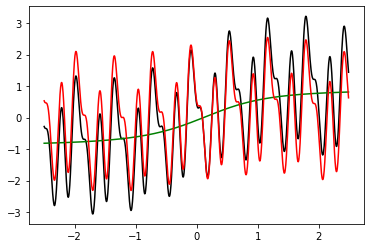

In [249]:
# compute r
predict_1 = predict_1.reshape(N0)
r = y0 - predict_1

plt.plot(x0, y0, color='black')
plt.plot(x0, predict_1, color='g')
plt.plot(x0, r, color='r')
plt.show()


# calculate r_p
px = 1/2/pi
rp = np.sqrt(px) * (r - np.mean(r))

In [250]:
# compute sum_low

e_low = 0
for i in range(N0-1):
    for j in range(N0-1): 
        sinc = 1
        if d == 1: 
            K = [1]
        else: 
            K = range(1,d)
        for k in K: 
            t = w0*(x0[j]**k - x0[i]**k)
            if t == 0: 
                sinc = sinc * 1
            else: 
                sinc = sinc * np.sin(t) / t
        e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
e_low = e_low / (N0**2) / y_var
print(e_low)

0.17618829961281723


In [251]:
# compute SB
var_r = np.var(r)
var_f = np.var(y)
FVU = var_r/var_f 
print(FVU)
SB = (FVU-2*e_low)/FVU
print(SB)

0.7464691925128109
0.5279422074480495


Epoch 1/100
16/16 [==============================] - 0s 733us/step - loss: 1.5634
Epoch 2/100
16/16 [==============================] - 0s 800us/step - loss: 1.5631
Epoch 3/100
16/16 [==============================] - 0s 734us/step - loss: 1.5596
Epoch 4/100
16/16 [==============================] - 0s 805us/step - loss: 1.5583
Epoch 5/100
16/16 [==============================] - 0s 800us/step - loss: 1.5549
Epoch 6/100
16/16 [==============================] - 0s 800us/step - loss: 1.5551
Epoch 7/100
16/16 [==============================] - 0s 728us/step - loss: 1.5589
Epoch 8/100
16/16 [==============================] - 0s 800us/step - loss: 1.5744
Epoch 9/100
16/16 [==============================] - 0s 734us/step - loss: 1.5651
Epoch 10/100
16/16 [==============================] - 0s 733us/step - loss: 1.5562
Epoch 11/100
16/16 [==============================] - 0s 800us/step - loss: 1.5517
Epoch 12/100
16/16 [==============================] - 0s 934us/step - loss: 1.5549
Epoch 13/100


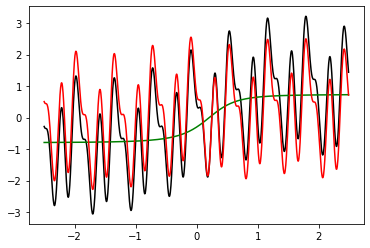

0.17309976791809722
0.744186225260946
0.5347944854598714


In [252]:
# fitting the data 
beta = model.fit(x_tr, y_tr, epochs=100, batch_size=32)

# predicting the data
predict_1 = model.predict(x0)

# compute r
predict_1 = predict_1.reshape(N0)
r = y0 - predict_1

plt.plot(x0, y0, color='black')
plt.plot(x0, predict_1, color='g')
plt.plot(x0, r, color='r')
plt.show()


# calculate r_p
px = 1/2/pi
rp = np.sqrt(px) * (r - np.mean(r))

# compute sum_low

e_low = 0
for i in range(N0-1):
    for j in range(N0-1): 
        sinc = 1
        if d == 1: 
            K = [1]
        else: 
            K = range(1,d)
        for k in K: 
            t = w0*(x0[j]**k - x0[i]**k)
            if t == 0: 
                sinc = sinc * 1
            else: 
                sinc = sinc * np.sin(t) / t
        e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
e_low = e_low / (N0**2) / y_var
print(e_low)

# compute SB
var_r = np.var(r)
var_f = np.var(y)
FVU = var_r/var_f 
print(FVU)
SB = (FVU-2*e_low)/FVU
print(SB)

Epoch 1/1000
16/16 [==============================] - 0s 734us/step - loss: 1.5446
Epoch 2/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5486
Epoch 3/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5568
Epoch 4/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5434
Epoch 5/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5409
Epoch 6/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5454
Epoch 7/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5505
Epoch 8/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5532
Epoch 9/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5528
Epoch 10/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5503
Epoch 11/1000
16/16 [==============================] - 0s 667us/step - loss: 1.5587
Epoch 12/1000
16/16 [==============================] - 0s 733us/step - loss: 1.5519
E

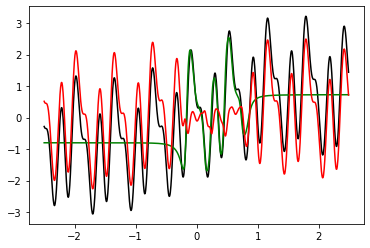

0.12157571661178555
0.5843260009087764
0.583877094557818


In [253]:
# fitting the data 
beta = model.fit(x_tr, y_tr, epochs=1000, batch_size=32)

# predicting the data
predict_1 = model.predict(x0)

# compute r
predict_1 = predict_1.reshape(N0)
r = y0 - predict_1

plt.plot(x0, y0, color='black')
plt.plot(x0, predict_1, color='g')
plt.plot(x0, r, color='r')
plt.show()


# calculate r_p
rp = np.sqrt(px) * (r - np.mean(r))

# compute sum_low

e_low = 0
for i in range(N0-1):
    for j in range(N0-1): 
        sinc = 1
        if d == 1: 
            K = [1]
        else: 
            K = range(1,d)
        for k in K: 
            t = w0*(x0[j]**k - x0[i]**k)
            if t == 0: 
                sinc = sinc * 1
            else: 
                sinc = sinc * np.sin(t) / t
        e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
e_low = e_low / (N0**2) / y_var
print(e_low)

# compute SB
var_r = np.var(r)
var_f = np.var(y)
FVU = var_r/var_f 
print(FVU)
SB = (FVU-2*e_low)/FVU
print(SB)

Epoch 1/3000
16/16 [==============================] - 0s 667us/step - loss: 1.2880
Epoch 2/3000
16/16 [==============================] - 0s 667us/step - loss: 1.2831
Epoch 3/3000
16/16 [==============================] - 0s 667us/step - loss: 1.2824
Epoch 4/3000
16/16 [==============================] - 0s 800us/step - loss: 1.2812
Epoch 5/3000
16/16 [==============================] - 0s 800us/step - loss: 1.2817
Epoch 6/3000
16/16 [==============================] - 0s 667us/step - loss: 1.2784
Epoch 7/3000
16/16 [==============================] - 0s 800us/step - loss: 1.2840
Epoch 8/3000
16/16 [==============================] - 0s 867us/step - loss: 1.2817
Epoch 9/3000
16/16 [==============================] - 0s 784us/step - loss: 1.2778
Epoch 10/3000
16/16 [==============================] - 0s 800us/step - loss: 1.2786
Epoch 11/3000
16/16 [==============================] - 0s 734us/step - loss: 1.2781
Epoch 12/3000
16/16 [==============================] - 0s 800us/step - loss: 1.2765
E

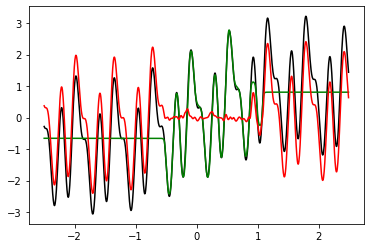

0.14438150450084025
0.5169521333664261
0.4414124821939762


In [254]:
# fitting the data 
beta = model.fit(x_tr, y_tr, epochs=3000, batch_size=32)

# predicting the data
predict_1 = model.predict(x0)

# compute r
predict_1 = predict_1.reshape(N0)
r = y0 - predict_1

plt.plot(x0, y0, color='black')
plt.plot(x0, predict_1, color='g')
plt.plot(x0, r, color='r')
plt.show()


# calculate r_p
px = 1/2/pi
rp = np.sqrt(px) * (r - np.mean(r))

# compute sum_low

e_low = 0
for i in range(N0-1):
    for j in range(N0-1): 
        sinc = 1
        if d == 1: 
            K = [1]
        else: 
            K = range(1,d)
        for k in K: 
            t = w0*(x0[j]**k - x0[i]**k)
            if t == 0: 
                sinc = sinc * 1
            else: 
                sinc = sinc * np.sin(t) / t
        e_low = e_low + rp[i]*rp[j]/px/px * (w0 **d / pi**d) * sinc 
e_low = e_low / (N0**2) / y_var
print(e_low)

# compute SB
var_r = np.var(r)
var_f = np.var(y)
FVU = var_r/var_f 
print(FVU)
SB = (FVU-2*e_low)/FVU
print(SB)